In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import ascii
import numpy as np
from astropy.io import fits
from scipy.stats import pearsonr

SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 20
lims = [[0.1,0.5],[0.6,1.0],np.log([0.25,4.0]),np.log([0.25,4.0]),np.log([0.5,2.0]),np.log([0.5,2.0])]
simpars = ['\Omega_m','\sigma_8','log(A_{SN1})','log(A_{AGN1})','log(A_{SN2})','log(A_{AGN2})']

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)

# import matplotlib.font_manager
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
# sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])
plt.rc('font', family='Times New Roman')

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'
# matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')
import seaborn as sns
sns.set_palette("muted")

In [2]:
lims = [[0.1,0.5],[0.6,1.0],np.log([0.25,4.0]),np.log([0.25,4.0]),np.log([0.5,2.0]),np.log([0.5,2.0])]
simpars = ['\Omega_m','\sigma_8','log(A_{SN1})','log(A_{AGN1})','log(A_{SN2})','log(A_{AGN2})']
label_table = np.loadtxt("CosmoAstroSeed_IllustrisTNG_L25n256_LH.txt", skiprows=1, usecols=range(1, 7))
corr_labels = np.vstack((label_table,label_table,label_table))
for i in range(corr_labels.shape[1]):
    if i>1:
        corr_labels[:,i] = np.log(corr_labels[:,i])
        
axes = ['x', 'y', 'z']

d = np.load("../wdplus_data.npz")# dictionary
r = d['r']
dat = {axis: d[axis] for axis in axes}
wdp = np.append(np.array(dat['x']), np.append(dat['y'],dat['z'],axis=0),axis=0)
d = np.load("../wdcross_data.npz")
dat = {axis: d[axis] for axis in axes}
wdx = np.append(np.array(dat['x']), np.append(dat['y'],dat['z'],axis=0),axis=0)
d = np.load("../wdd_data.npz")
wdd = np.array(d['wgg'])


In [3]:
data = np.loadtxt("../sim_galaxyProperties.txt", skiprows=1)  # Skip the header row
mean_SFR, mean_SSFR, mean_e, std_e = data.T
print(mean_SFR.shape)

(1000,)


### Coloring in scatterplot by mean SFR

(3000,)


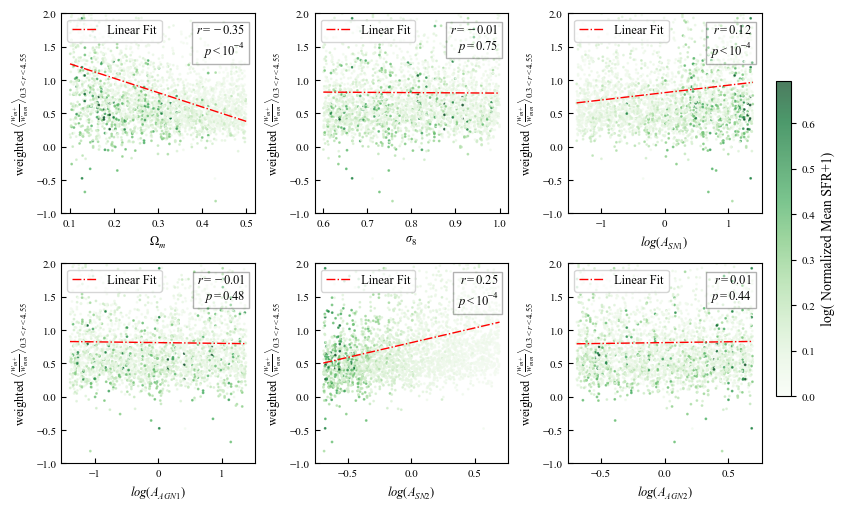

In [4]:
corr_data = wdp[:,:4]/wdd[:,:4]
weights = 1/np.std(corr_data,axis=0)
wtd_corr_data = corr_data*weights

mean_SFR_ = np.vstack((mean_SFR,mean_SFR,mean_SFR)).reshape(3000,)
print(mean_SFR_.shape)
norm_mean_SFR =  np.log( (mean_SFR_ - min(mean_SFR_)) / (max(mean_SFR_) - min(mean_SFR_)) +1)

fig, axes = plt.subplots(2, 3, figsize=(25/3, 5))  # 2 rows, 3 columns
axes = axes.flatten()  
for param in range(6):
    ax = axes[param]
    avg_corr = np.mean(wtd_corr_data, axis=1)
    pearson_coeff, p_value = pearsonr(avg_corr, corr_labels[:, param])

    # Fit a straight line (linear regression)
    slope, intercept = np.polyfit(corr_labels[:, param], avg_corr, 1)
    x_vals = np.linspace(min(lims[param]), max(lims[param]), 10)
    y_vals = slope * x_vals + intercept

    # Plot the trend line
#     ax.axhline(np.mean(wtd_corr_data), c='0.5', linewidth=0.2, linestyle='-',label='')
    ax.plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")
    
    if p_value>1e-4:
        ax.text( 0.95, 0.95, 
        f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
        transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    else:
        ax.text(0.95, 0.95, f"$r={pearson_coeff:.2f}$\n"+r'$p<10^{-4}$', transform=ax.transAxes, 
        fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="square", edgecolor='black',facecolor='white', alpha=0.3))
    
#     ax.hexbin(corr_labels[:, param], avg_corr, gridsize=16, extent=(lims[param][0], lims[param][1], -1, 2),cmap='Blues')
    scatter = ax.scatter(corr_labels[:, param], avg_corr, s=1, c=norm_mean_SFR, cmap=mpl.cm.Greens,alpha=0.7,label="")
    
    ax.set_xlabel(f"${simpars[param]}$",fontsize=9)
    ax.set_ylabel(r"weighted $\langle \frac{w_{m+}}{w_{mm}} \rangle_{0.3<r<4.55}$",fontsize=9)
    ax.legend(fontsize=9,loc='upper left')
    ax.tick_params(direction='in')
    ax.set_ylim([-1, 2])
    
cbar = fig.colorbar(scatter, ax=axes, orientation='vertical', shrink=0.7, pad=0.02)
cbar.set_label('log( Normalized Mean SFR+1)', fontsize=10)
fig.set_constrained_layout(True)
plt.savefig('/Users/danie/Library/CloudStorage/OneDrive-Personal/Physics UCL/Year 3/Astro Research Project 2023/ParamDependenceSFR.pdf', dpi=300)

plt.show()

(3000,)


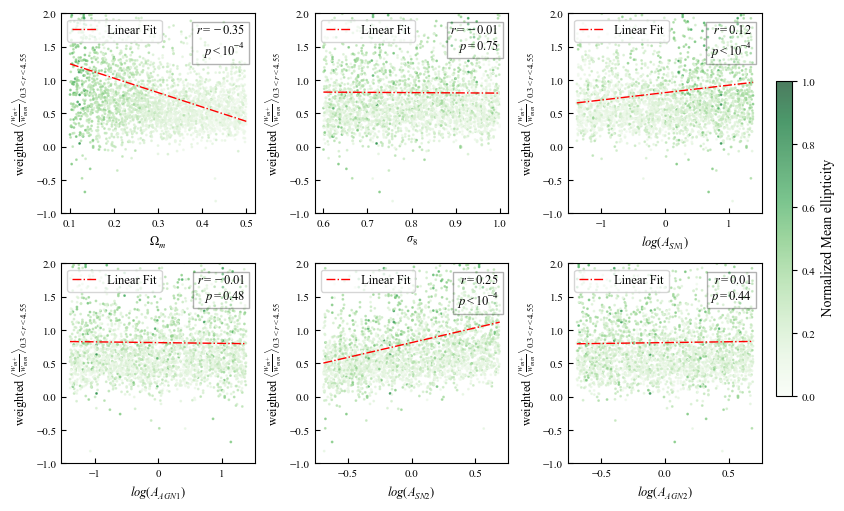

In [5]:
corr_data = wdp[:,:4]/wdd[:,:4]
weights = 1/np.std(corr_data,axis=0)
wtd_corr_data = corr_data*weights

mean_e_ = np.vstack((mean_e,mean_e,mean_e)).reshape(3000,)
print(mean_SFR_.shape)
norm_mean_SFR =   (mean_e_ - min(mean_e_)) / (max(mean_e_) - min(mean_e_)) 

fig, axes = plt.subplots(2, 3, figsize=(25/3, 5))  # 2 rows, 3 columns
axes = axes.flatten()  
for param in range(6):
    ax = axes[param]
    avg_corr = np.mean(wtd_corr_data, axis=1)
    pearson_coeff, p_value = pearsonr(avg_corr, corr_labels[:, param])

    # Fit a straight line (linear regression)
    slope, intercept = np.polyfit(corr_labels[:, param], avg_corr, 1)
    x_vals = np.linspace(min(lims[param]), max(lims[param]), 10)
    y_vals = slope * x_vals + intercept

    # Plot the trend line
#     ax.axhline(np.mean(wtd_corr_data), c='0.5', linewidth=0.2, linestyle='-',label='')
    ax.plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")
    
    if p_value>1e-4:
        ax.text( 0.95, 0.95, 
        f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
        transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    else:
        ax.text(0.95, 0.95, f"$r={pearson_coeff:.2f}$\n"+r'$p<10^{-4}$', transform=ax.transAxes, 
        fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="square", edgecolor='black',facecolor='white', alpha=0.3))
    
#     ax.hexbin(corr_labels[:, param], avg_corr, gridsize=16, extent=(lims[param][0], lims[param][1], -1, 2),cmap='Blues')
    scatter = ax.scatter(corr_labels[:, param], avg_corr, s=1, c=norm_mean_SFR, cmap=mpl.cm.Greens,alpha=0.7,label="")
    
    ax.set_xlabel(f"${simpars[param]}$",fontsize=9)
    ax.set_ylabel(r"weighted $\langle \frac{w_{m+}}{w_{mm}} \rangle_{0.3<r<4.55}$",fontsize=9)
    ax.legend(fontsize=9,loc='upper left')
    ax.tick_params(direction='in')
    ax.set_ylim([-1, 2])
    
cbar = fig.colorbar(scatter, ax=axes, orientation='vertical', shrink=0.7, pad=0.02)
cbar.set_label(' Normalized Mean ellipticity', fontsize=10)
fig.set_constrained_layout(True)
plt.savefig('/Users/danie/Library/CloudStorage/OneDrive-Personal/Physics UCL/Year 3/Astro Research Project 2023/ParamDependenceEpsilon.pdf', dpi=300)

plt.show()

In [6]:
wgplusses = []
wgcrosses = []
ggs = []

In [7]:
wgplusses_x = []
wgcrosses_x = []
ggs_x = []
for i in range(0,1000):
    for j, f in enumerate((f'../correlatingDM-folder/OUTPUT_CAMELS_DM_NOMAG_LH_x/wgp_LH{i}.dat',f'../correlatingDM-folder/OUTPUT_CAMELS_DM_NOMAG_LH_x/wgg_LH{i}.dat')):
        dat = ascii.read(f)
        if j == 0:
#             print(dat.colnames)
#             print(dat['meanr'])
            r, wgp, wgx = dat['rnom'], dat['wgplus'], dat['wgcross']
        elif j == 1:
            r, wgg = dat['rnom'], dat['wgg']
    
    wgplusses_x.append(wgp)
    wgcrosses_x.append(wgx)
    ggs_x.append(wgg)
    wgplusses.append(wgp)
    wgcrosses.append(wgx)
    ggs.append(wgg)

In [8]:
wgplusses_y = []
wgcrosses_y = []
ggs_y = []
for i in range(0,1000):
    for j, f in enumerate((f'../correlatingDM-folder/OUTPUT_CAMELS_DM_NOMAG_LH_y/wgp_LH{i}.dat',f'../correlatingDM-folder/OUTPUT_CAMELS_DM_NOMAG_LH_y/wgg_LH{i}.dat')):
        dat = ascii.read(f)
        if j == 0:
#             print(dat.colnames)
#             print(dat['meanr'])
            r, wgp, wgx = dat['rnom'], dat['wgplus'], dat['wgcross']
        elif j == 1:
            r, wgg = dat['rnom'], dat['wgg']
    
    wgplusses_y.append(wgp)
    wgcrosses_y.append(wgx)
    ggs_y.append(wgg)
    wgplusses.append(wgp)
    wgcrosses.append(wgx)
    ggs.append(wgg)

In [9]:
wgplusses_z = []
wgcrosses_z = []
ggs_z = []
for i in range(0,1000):
    for j, f in enumerate((f'../correlatingDM-folder/OUTPUT_CAMELS_DM_NOMAG_LH_z/wgp_LH{i}.dat',f'../correlatingDM-folder/OUTPUT_CAMELS_DM_NOMAG_LH_z/wgg_LH{i}.dat')):
        dat = ascii.read(f)
        if j == 0:
#             print(dat.colnames)
#             print(dat['meanr'])
            r, wgp, wgx = dat['rnom'], dat['wgplus'], dat['wgcross']
        elif j == 1:
            r, wgg = dat['rnom'], dat['wgg']
    
    wgplusses_z.append(wgp)
    wgcrosses_z.append(wgx)
    ggs_z.append(wgg)
    wgplusses.append(wgp)
    wgcrosses.append(wgx)
    ggs.append(wgg)

In [17]:
wdplusses = np.array(wgplusses)
wdcrosses = np.array(wgcrosses)
wgplusses_x = np.array(wgplusses_x);
wgplusses_y = np.array(wgplusses_y); 
wgplusses_z = np.array(wgplusses_z)
wgcrosses_x = np.array(wgcrosses_x); 
wgcrosses_y = np.array(wgcrosses_y);
wgcrosses_z = np.array(wgcrosses_z)
ggs = np.array(ggs)
print(np.sum(np.isnan(wgplusses)), np.sum(np.isnan(wgcrosses)), np.sum(np.isnan(ggs)),ggs.shape)

0 0 0 (3000, 7)


In [18]:
d = np.load("../wdplus_data.npz")
# dictionary
axes = ['x', 'y', 'z']
r = d['r']
dat = {axis: d[axis] for axis in axes}
wdplusses_mag = np.append(np.array(dat['x']), np.append(dat['y'],dat['z'],axis=0),axis=0)
d = np.load("../wdcross_data.npz")
dat = {axis: d[axis] for axis in axes}
wdcrosses_mag = np.append(np.array(dat['x']), np.append(dat['y'],dat['z'],axis=0),axis=0)

d = np.load("../wdd_data.npz")
wdd = np.array(d['wgg'])

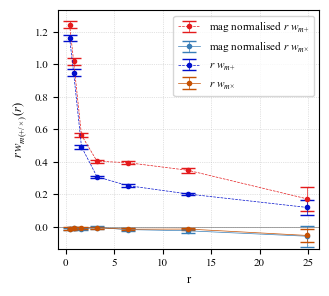

In [15]:
sqrtN = np.sqrt(wgplusses.shape[0])
r_wdplusses = wdplusses*r
r_wdcrosses = wdcrosses*r

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10/3,3))
ax.axhline(0,c='0.5',linewidth=0.5)
ax.errorbar(r,np.mean(r_wdplusses,axis=0), yerr=np.std(r_wdplusses,axis=0)/sqrtN, linewidth=0.5, linestyle='--', elinewidth=0.5
               , capsize=5 ,label=r'mag normalised $r$ $w_{m{+}}$', marker='o',markersize=3)
ax.errorbar(r,np.mean(r_wdcrosses,axis=0), yerr=np.std(r_wdcrosses,axis=0)/sqrtN, linewidth=0.5, elinewidth=0.5 
               , capsize=5,label=r'mag normalised $r$ $w_{m {\times}}$', marker='o',markersize=3)
r_wdplusses_mag = wdplusses_mag*r
r_wdcrosses_mag = wdcrosses_mag*r
ax.errorbar(r,np.mean(r_wdplusses_mag,axis=0), yerr=np.std(r_wdplusses_mag,axis=0)/sqrtN, linewidth=0.5, linestyle='--', elinewidth=0.5
               , capsize=5 ,label=r'$r$ $w_{m{+}}$', marker='o',markersize=3, color='xkcd:true blue')
ax.errorbar(r,np.mean(r_wdcrosses_mag,axis=0), yerr=np.std(r_wdcrosses_mag,axis=0)/sqrtN, linewidth=0.5, elinewidth=0.5 
               , capsize=5,label=r'$r$ $w_{m {\times}}$', marker='o',markersize=3,color='xkcd:dark orange')

ax.grid(which='both', linestyle='dotted', linewidth=0.5, alpha=0.7)
ax.set_ylim(-0.1*np.abs(ax.get_ylim()).max(), np.abs(ax.get_ylim()).max())
# ax[0].set_title(r"LH (0 - 1000) average position-shape")
ax.set_xlabel("r")
ax.set_ylabel(r"$r \, w_{m(+/\times)}(r)$")
ax.legend() 
fig.tight_layout()
plt.savefig(
    '/Users/danie/Library/CloudStorage/OneDrive-Personal/Physics UCL/Year 3/Astro Research Project 2023/avg_correlationsMAGNORM.pdf',
    dpi=300, bbox_inches='tight'
)

/var/folders/2k/4lvm79j14sg5_v8dqx8tly7h0000gn/T/ipykernel_22678/3236512126.py:40: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0,30)


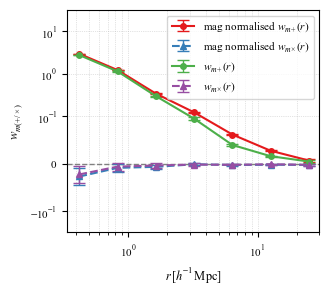

In [14]:
sns.set_palette("Set1")
sqrtN = np.sqrt(wgplusses.shape[0])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10/3, 3))  # Width-to-height ratio adjusted for a clean layout
ax.axhline(0, c='0.5', linewidth=1, linestyle='--')
ax.errorbar(
    r, np.mean(wdplusses, axis=0), yerr=np.std(wgplusses, axis=0) / sqrtN,
    linewidth=1.5, linestyle='-', elinewidth=1, capsize=4,
    label=r'mag normalised $w_{m{+}}\,(r)$', marker='o', markersize=4
)
ax.errorbar(
    r, np.mean(wdcrosses, axis=0), yerr=np.std(wgcrosses, axis=0) / sqrtN,
    linewidth=1.5, linestyle='--', elinewidth=1, capsize=4,
    label=r'mag normalised $w_{m{\times}}\,(r)$', marker='^', markersize=4
)


ax.errorbar(
    r, np.mean(wdplusses_mag, axis=0), yerr=np.std(wgplusses, axis=0) / sqrtN,
    linewidth=1.5, linestyle='-', elinewidth=1, capsize=4,
    label=r'$w_{m{+}}\,(r)$', marker='o', markersize=4
)
ax.errorbar(
    r, np.mean(wdcrosses_mag, axis=0), yerr=np.std(wgcrosses, axis=0) / sqrtN,
    linewidth=1.5, linestyle='--', elinewidth=1, capsize=4,
    label=r'$w_{m{\times}}\,(r)$', marker='^', markersize=4
)

# Grid and scaling

ax.grid(which='both', linestyle='dotted', linewidth=0.5, alpha=0.7)
ax.set_xscale('log')  # Example for log scale x-axis
ax.set_yscale('symlog', linthresh=1e-1)  # Example for log scale y-axis
ax.set_xlim(np.min(r) * 0.8, np.max(r) * 1.2)

# Adjust y-limits to be symmetric
ax.set_ylim(
    -0.1 * np.abs(ax.get_ylim()).max(), 10*np.abs(ax.get_ylim()).max()
)
ax.set_xlim(0,30)



# Axis labels and titles
ax.set_xlabel(r"$r \, [h^{-1} \, \mathrm{Mpc}]$")
ax.set_ylabel(r"$w_{m(+/\times)}$")
ax.legend()



# Adjust layout and save
fig.tight_layout()

plt.show()

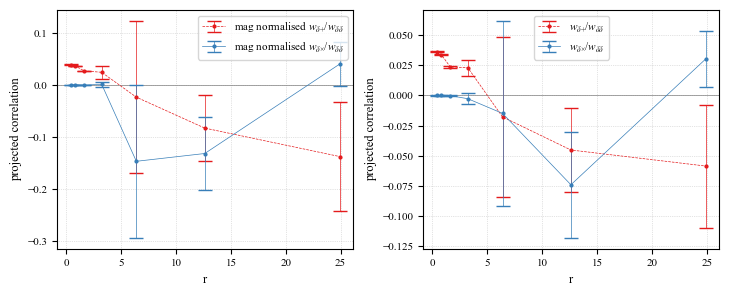

In [20]:
d_wdplusses = wdplusses[:]/wdd
d_wdcrosses = wdcrosses[:]/wdd
d_wdplusses_mag = wdplusses_mag/wdd
d_wdcrosses_mag = wdcrosses_mag/wdd

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(22/3,3))
ax[0].axhline(0,c='0.5',linewidth=0.5)
ax[0].errorbar(r,np.mean(d_wdplusses,axis=0), yerr=np.std(d_wdplusses,axis=0)/sqrtN, linewidth=0.5, linestyle='--', elinewidth=0.5
               , capsize=5 ,label=r'mag normalised $w_{\delta{+}}/w_{\delta\delta}$', marker='o',markersize=2)
ax[0].errorbar(r,np.mean(d_wdcrosses,axis=0), yerr=np.std(d_wdcrosses,axis=0)/sqrtN, linewidth=0.5, elinewidth=0.5 
               , capsize=5,label=r'mag normalised $w_{\delta {\times}}/w_{\delta\delta}$', marker='o',markersize=2)
ax[0].grid(which='both', linestyle='dotted', linewidth=0.5, alpha=0.7)
ax[1].axhline(0,c='0.5',linewidth=0.5)
ax[1].errorbar(r,np.mean(d_wdplusses_mag,axis=0), yerr=np.std(d_wdplusses_mag,axis=0)/sqrtN, linewidth=0.5, linestyle='--', elinewidth=0.5
               , capsize=5 ,label=r'$w_{\delta{+}}/w_{\delta\delta}$', marker='o',markersize=2)
ax[1].errorbar(r,np.mean(d_wdcrosses_mag,axis=0), yerr=np.std(d_wdcrosses_mag,axis=0)/sqrtN, linewidth=0.5, elinewidth=0.5 
               , capsize=5,label=r'$w_{\delta {\times}}/w_{\delta\delta}$', marker='o',markersize=2)
ax[1].grid(which='both', linestyle='dotted', linewidth=0.5, alpha=0.7)
ax[0].set_xlabel("r")
ax[0].set_ylabel(r"projected correlation")
ax[0].legend() 
ax[1].set_xlabel("r")
ax[1].set_ylabel(r"projected correlation")
ax[1].legend() 
fig.tight_layout()

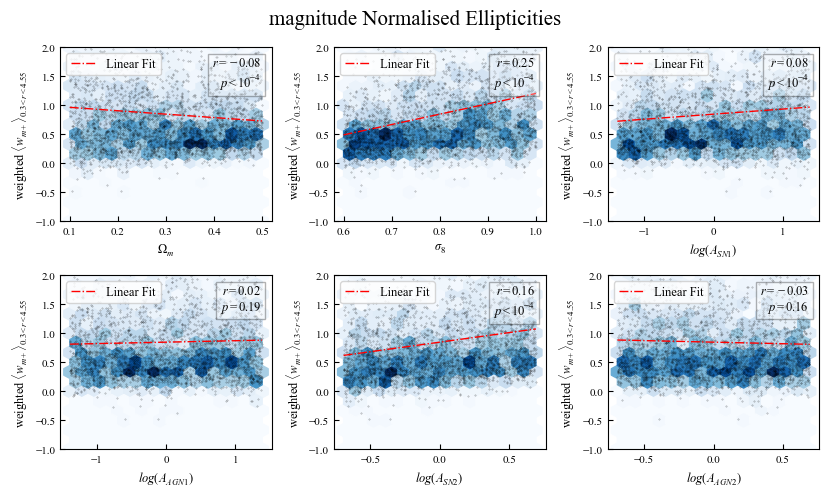

In [44]:
corr_data = wdplusses_mag[:,:4]#/wdd[:,:4]
weights = 1/np.std(corr_data,axis=0)
wtd_corr_data = corr_data*weights

fig, axes = plt.subplots(2, 3, figsize=(25/3, 5))  # 2 rows, 3 columns
axes = axes.flatten()  
fig.suptitle('magnitude Normalised Ellipticities',fontsize=15)
for param in range(6):
    ax = axes[param]
    avg_corr = np.mean(wtd_corr_data, axis=1)
    pearson_coeff, p_value = pearsonr(avg_corr, corr_labels[:, param])

    # Fit a straight line (linear regression)
    slope, intercept = np.polyfit(corr_labels[:, param], avg_corr, 1)
    x_vals = np.linspace(min(lims[param]), max(lims[param]), 10)
    y_vals = slope * x_vals + intercept

    # Plot the trend line
#     ax.axhline(np.mean(wtd_corr_data), c='0.5', linewidth=0.2, linestyle='-',label='')
    ax.plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")
    
    if p_value>1e-4:
        ax.text( 0.95, 0.95, 
        f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
        transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    else:
        ax.text(0.95, 0.95, f"$r={pearson_coeff:.2f}$\n"+r'$p<10^{-4}$', transform=ax.transAxes, 
        fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="square", edgecolor='black',facecolor='white', alpha=0.3))
    
    ax.hexbin(corr_labels[:, param], avg_corr, gridsize=16, extent=(lims[param][0], lims[param][1], -1, 2),cmap='Blues')
    ax.scatter(corr_labels[:, param], avg_corr, s=0.1, color='black',alpha=0.4,label="")
    
    ax.set_xlabel(f"${simpars[param]}$",fontsize=9)
    ax.set_ylabel(r"weighted $\langle w_{m+} \rangle_{0.3<r<4.55}$",fontsize=9)
    ax.legend(fontsize=9,loc='upper left')
    ax.tick_params(direction='in')
    ax.set_ylim([-1, 2])
plt.tight_layout()
# plt.savefig(
#     '/Users/danie/Library/CloudStorage/OneDrive-Personal/Physics UCL/Year 3/Astro Research Project 2023/ell mag normanised.pdf',
#     dpi=300, bbox_inches='tight'
# )
plt.show()